In [1]:
from unityagents import UnityEnvironment
import numpy as np

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from ddpg_agent_1 import Agent

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_1/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
# Agent default hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 2e-4         # learning rate of the actor 
LR_CRITIC = 2e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
ACTOR_FC1_UNITS = 128   # Number of units for the layer 1 in the actor model
ACTOR_FC2_UNITS = 128   # Number of units for the layer 2 in the actor model
CRITIC_FCS1_UNITS = 128 # Number of units for the layer 1 in the critic model
CRITIC_FC2_UNITS = 128  # Number of units for the layer 2 in the critic model
ADD_OU_NOISE = True     # Add Ornstein-Uhlenbeck noise
MU = 0.                 # Ornstein-Uhlenbeck noise parameter
THETA = 0.15            # Ornstein-Uhlenbeck noise parameter
SIGMA = 0.1             # Ornstein-Uhlenbeck noise parameter


In [6]:
agent = Agent(state_size=state_size,action_size=action_size, random_seed=10,
                  actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
                  critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS,
                  buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE,
                  gamma=GAMMA, tau=TAU,
                  lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
                  add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=SIGMA)


[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 lr_actor=0.0002 lr_critic=0.0002 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 



In [7]:
def ddpg(n_episodes=1000, max_t=1000, window_size=100, score_threshold=30.0, 
         print_interval=10, epochs=1000):
    
    scores_deque = deque(maxlen=window_size)
    scores = []
    best_average_score = -np.inf

    for i_episode in range(1, epochs+1):
        
        env_info = env.reset(train_mode=True)[brain_name]     
        state = env_info.vector_observations[0]
        
        agent.reset()
        score = 0
        
        for t in range(max_t):
            action = agent.act(state)
            env_info=env.step(action)[brain_name]        # send action to the environment
            next_state = env_info.vector_observations[0] # get next state (Single Agent)
            reward = env_info.rewards[0]                 # get reward (Single Agent)
            done = env_info.local_done[0]                # see if episode finished (Single Agent)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_deque.append(score)
        scores.append(score)
        average_score = np.mean(scores_deque)
        
        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, score), end="")
        if i_episode % print_interval == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, score))
        
        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'output/ddpg_1_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'output/ddpg_1_checkpoint_critic.pth')
            break

    np.save('output/ddpg_1_scores.npy', scores)  
    return scores

In [8]:
scores = ddpg()

Episode: 10	Average Score: 0.16	Current Score: 0.91
Episode: 20	Average Score: 0.67	Current Score: 1.28
Episode: 30	Average Score: 1.07	Current Score: 2.23
Episode: 40	Average Score: 1.46	Current Score: 2.05
Episode: 50	Average Score: 1.89	Current Score: 4.63
Episode: 60	Average Score: 2.28	Current Score: 3.77
Episode: 70	Average Score: 2.78	Current Score: 12.89
Episode: 80	Average Score: 3.57	Current Score: 7.606
Episode: 90	Average Score: 4.47	Current Score: 9.249
Episode: 100	Average Score: 5.12	Current Score: 15.43
Episode: 110	Average Score: 6.58	Current Score: 15.87
Episode: 120	Average Score: 8.03	Current Score: 24.28
Episode: 130	Average Score: 10.17	Current Score: 14.38
Episode: 140	Average Score: 12.10	Current Score: 23.99
Episode: 150	Average Score: 14.46	Current Score: 33.88
Episode: 160	Average Score: 17.12	Current Score: 21.49
Episode: 170	Average Score: 19.81	Current Score: 37.17
Episode: 180	Average Score: 21.97	Current Score: 28.77
Episode: 190	Average Score: 24.41	Cur

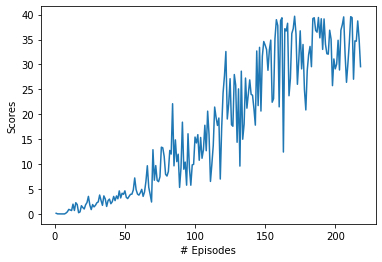

In [9]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')
plt.savefig('output/ddpg_1_scores_plot.png')
plt.show()

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
env.close()